In [14]:
# IMPORTS
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
import matplotlib.animation as animation
import json
import ntpath

## **load mixamo json**

In [12]:
json_object = None
file_name = 'mediapipe_json/mixamo_attack.gif.json.json' 
with open(file_name) as f:
    json_object = json.load(f)

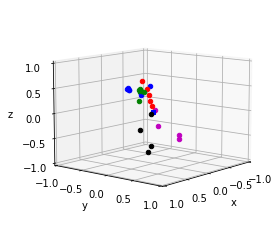

In [20]:
draw_mixamo(json_object, 1, 400)

## **to Binding Pose**

In [ ]:
def getBindingPose(resultJson, keypointsJson):
    res